# MNIST (0~9) Self-Organizing Map (SOM) 데모

MNIST 숫자 데이터(0~9) **10개 클래스 전체**로 SOM을 학습하고, **hex(육각) topology**로 U-Matrix / Label map을 시각화합니다.

- 데이터: MNIST (28×28)
- 클래스: 0~9 (10개)
- 입력: 784차원 (옵션: PCA로 축소)

In [1]:
# 필수 임포트 + SOM 모듈 경로 설정
import sys
import numpy as np
import matplotlib.pyplot as plt

# 이 노트북 위치: self-organizing-map/model-test/simple_example
# SOM 구현은 상위 폴더(model-test)의 som.py에 있음
sys.path.append('..')

from som import SelfOrganizingMap

# 재현성
SEED = 42
rng = np.random.default_rng(SEED)
np.random.seed(SEED)

plt.rcParams['figure.figsize'] = (10, 4)
plt.rcParams['font.size'] = 12

print('Imports OK')

Imports OK


2026-02-07 02:04:19.927881: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-07 02:04:20.185067: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-07 02:04:20.185114: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-07 02:04:20.227522: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-02-07 02:04:20.307555: I tensorflow/core/platform/cpu_feature_guar

MNIST: (70000, 28, 28) (70000,) labels: [0 1 2 3 4 5 6 7 8 9]
Sampled: (15000, 28, 28) class balance: [1500 1500 1500 1500 1500 1500 1500 1500 1500 1500]


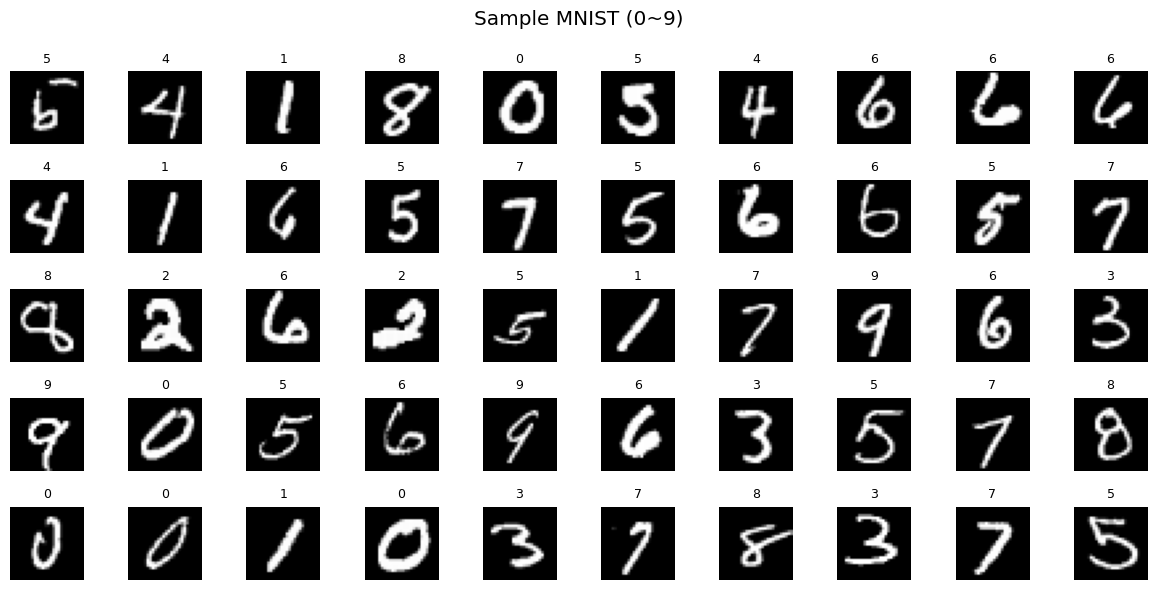

In [2]:
# MNIST 로드 (가능하면 keras 사용, 없으면 OpenML로 fallback)
def load_mnist():
    # 1) tensorflow/keras (보통 가장 간단)
    try:
        from tensorflow.keras.datasets import mnist  # type: ignore
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
        x = np.concatenate([x_train, x_test], axis=0)
        y = np.concatenate([y_train, y_test], axis=0)
        return x, y
    except Exception as e1:
        print('Keras MNIST load failed:', repr(e1))
        # 2) sklearn OpenML (네트워크 필요할 수 있음)
        try:
            from sklearn.datasets import fetch_openml  # type: ignore
            X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
            x = X.reshape(-1, 28, 28).astype(np.uint8)
            y = y.astype(int)
            return x, y
        except Exception as e2:
            raise RuntimeError(
                'MNIST를 로드할 수 없습니다. '
                'tensorflow(keras) 설치 또는 네트워크가 되는 환경에서 OpenML을 사용하세요.'
            ) from e2

x_all, y_all = load_mnist()
y_all = y_all.astype(int)
print('MNIST:', x_all.shape, y_all.shape, 'labels:', np.unique(y_all))

# 0~9 전체 사용 + 클래스 균형 샘플링
N_PER_CLASS = 1500  # 10클래스면 1k~2k 정도가 적당(빠르게 확인용)

idx_list = []
for k in range(10):
    idx_k = np.where(y_all == k)[0]
    rng.shuffle(idx_k)
    idx_list.append(idx_k[:N_PER_CLASS])

idx = np.concatenate(idx_list)
rng.shuffle(idx)

x10 = x_all[idx]
y10 = y_all[idx]

print('Sampled:', x10.shape, 'class balance:', np.bincount(y10, minlength=10))

# 샘플 시각화 (5x10)
plt.figure(figsize=(12, 6))
for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.imshow(x10[i], cmap='gray')
    plt.title(int(y10[i]), fontsize=9)
    plt.axis('off')
plt.suptitle('Sample MNIST (0~9)')
plt.tight_layout()
plt.show()

In [3]:
# SOM 입력 벡터 생성: (N, 28, 28) -> (N, 784) + 정규화
X = x10.reshape(len(x10), -1).astype(np.float32) / 255.0
y = y10.astype(int)

# per-sample 표준화: 전체 밝기/대비 차이 감소
X = (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True) + 1e-8)

print('X:', X.shape, 'y:', y.shape, 'y unique:', np.unique(y))

X: (15000, 784) y: (15000,) y unique: [0 1 2 3 4 5 6 7 8 9]


In [4]:
# 결과 개선용 튜닝 옵션 (여기만 바꿔보면 됩니다)
# 1) 거리함수: 이미지(고차원)에서는 cosine이 종종 더 잘 뭉칩니다.
DISTANCE_FN = 'cosine'   # 'euclidean' | 'cosine' | 'manhattan'

# 2) cosine을 쓸 때는 L2 정규화(단위벡터)가 보통 안정적입니다.
USE_L2_NORMALIZE = True

# 3) 가중치 초기화: 데이터에서 샘플링해 초기화하면 수렴이 빨라지고 결과가 깔끔해지는 경우가 많습니다.
INIT_WEIGHTS_FROM_DATA = True

# 4) 2단계 학습: (거친 정렬) -> (미세 조정)
USE_TWO_PHASE_TRAIN = True

# 5) 맵/반복 수: 분리가 아쉬우면 여기부터 올려보세요.
MAP_SIZE = (36, 36)
NUM_ITER_COARSE = 12000
NUM_ITER_FINE = 12000

# 6) 이웃반경/학습률: coarse는 크게, fine은 작게
SIGMA_COARSE = max(MAP_SIZE) / 2      # 예: 18
LR_COARSE = 0.5
SIGMA_FINE = 2.0
LR_FINE = 0.15

print('[Tuning] distance=', DISTANCE_FN, 'L2=', USE_L2_NORMALIZE, 'init_from_data=', INIT_WEIGHTS_FROM_DATA, 'two_phase=', USE_TWO_PHASE_TRAIN)

[Tuning] distance= cosine L2= True init_from_data= True two_phase= True


In [5]:
# (옵션) PCA로 차원 축소 후 SOM 학습
USE_PCA = True
PCA_DIM = 64  # 10클래스면 32~96 추천

# 주의: 기존 코드의 QE는 (항상) 유클리드 기준으로 계산됩니다.
# 지금처럼 cosine 거리/정규화를 쓰면 유클리드 QE 스케일이 달라져서 "수치"가 커질 수 있어요.
# 그래서 아래에서 '모델 기준 QE(=거리함수 기준)'도 같이 출력합니다.
if USE_PCA:
    from sklearn.decomposition import PCA  # type: ignore
    # whiten=True는 스케일을 바꿔 유클리드 QE가 커져 보일 수 있어 기본은 False로 둡니다.
    pca = PCA(n_components=PCA_DIM, random_state=SEED, whiten=False)
    X_in = pca.fit_transform(X)
    print(f'PCA: {X.shape[1]} -> {X_in.shape[1]}')
    print(f'Explained variance sum: {pca.explained_variance_ratio_.sum():.4f}')
else:
    X_in = X
    print('PCA skipped')

# cosine 거리 쓸 때는 unit-norm이 안정적
if USE_L2_NORMALIZE:
    n = np.linalg.norm(X_in, axis=1, keepdims=True) + 1e-8
    X_in = X_in / n
    print('Applied L2-normalization to X_in')

# SOM 설정
TOPOLOGY = 'hex'
HEX_RADIUS = 1.0

som = SelfOrganizingMap(
    map_size=MAP_SIZE,
    input_dim=X_in.shape[1],
    sigma=SIGMA_COARSE,
    learning_rate=LR_COARSE,
    decay_function='exponential',
    distance_fn=DISTANCE_FN,
    topology=TOPOLOGY,
    hex_radius=HEX_RADIUS,
    random_seed=SEED,
 )

if INIT_WEIGHTS_FROM_DATA:
    som.init_weights_from_data(X_in)
    print('Initialized weights from data samples')

def qe_by_distance_fn(som, data):
    # som.predict()는 som.distance_fn 기준 BMU를 사용합니다.
    # 여기서는 동일한 distance_fn으로 QE를 계산해서 비교 가능하게 합니다.
    if DISTANCE_FN == 'cosine':
        # cosine distance = 1 - cos sim
        w = som.weights
        errs = []
        for x in data:
            r, c = som.predict(x)
            ww = w[r, c]
            denom = (np.linalg.norm(x) * np.linalg.norm(ww) + 1e-10)
            errs.append(1.0 - float(np.dot(x, ww) / denom))
        return float(np.mean(errs))
    elif DISTANCE_FN == 'manhattan':
        w = som.weights
        errs = []
        for x in data:
            r, c = som.predict(x)
            errs.append(float(np.sum(np.abs(x - w[r, c]))))
        return float(np.mean(errs))
    else:
        # euclidean
        return float(som.quantization_error(data))

if USE_TWO_PHASE_TRAIN:
    print('Training SOM (coarse)...')
    som.sigma_0 = SIGMA_COARSE
    som.learning_rate_0 = LR_COARSE
    som.train(X_in, num_iterations=NUM_ITER_COARSE, verbose=True)

    # cosine일 때는 가중치도 단위벡터로 맞춰주는 게 안정적(스케일 드리프트 방지)
    if DISTANCE_FN == 'cosine':
        wn = np.linalg.norm(som.weights, axis=2, keepdims=True) + 1e-8
        som.weights = som.weights / wn

    print('Training SOM (fine)...')
    som.sigma_0 = SIGMA_FINE
    som.learning_rate_0 = LR_FINE
    som.train(X_in, num_iterations=NUM_ITER_FINE, verbose=True)
else:
    NUM_ITER = NUM_ITER_COARSE
    print('Training SOM...')
    som.sigma_0 = SIGMA_COARSE
    som.learning_rate_0 = LR_COARSE
    som.train(X_in, num_iterations=NUM_ITER, verbose=True)

print('Done')
print(f"Topographic Error: {som.topographic_error(X_in):.4f}")
print(f"QE (model distance_fn='{DISTANCE_FN}'): {qe_by_distance_fn(som, X_in):.4f}")
print(f"QE (euclidean, 참고용): {som.quantization_error(X_in):.4f}")

PCA: 784 -> 64
Explained variance sum: 0.8511
Applied L2-normalization to X_in
Initialized weights from data samples
Training SOM (coarse)...


KeyboardInterrupt: 

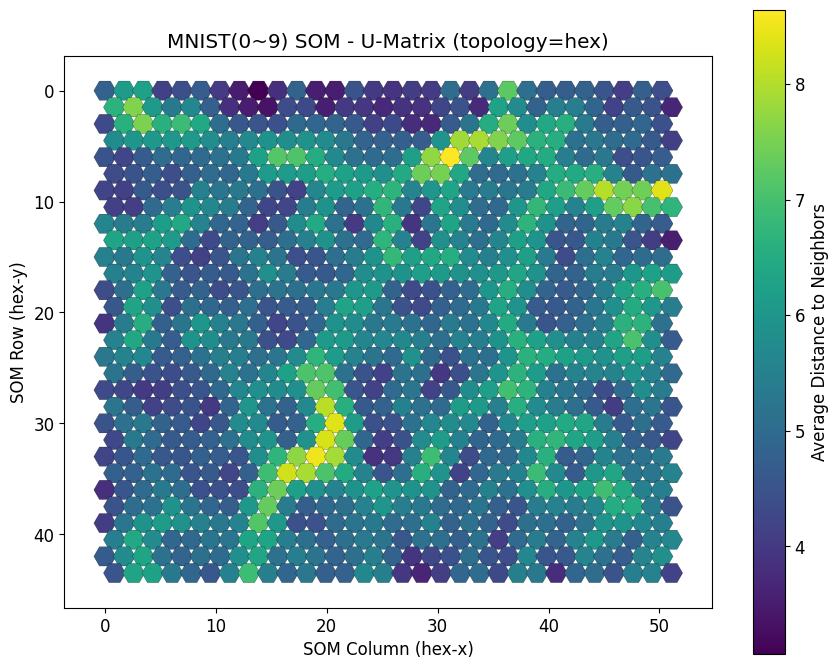

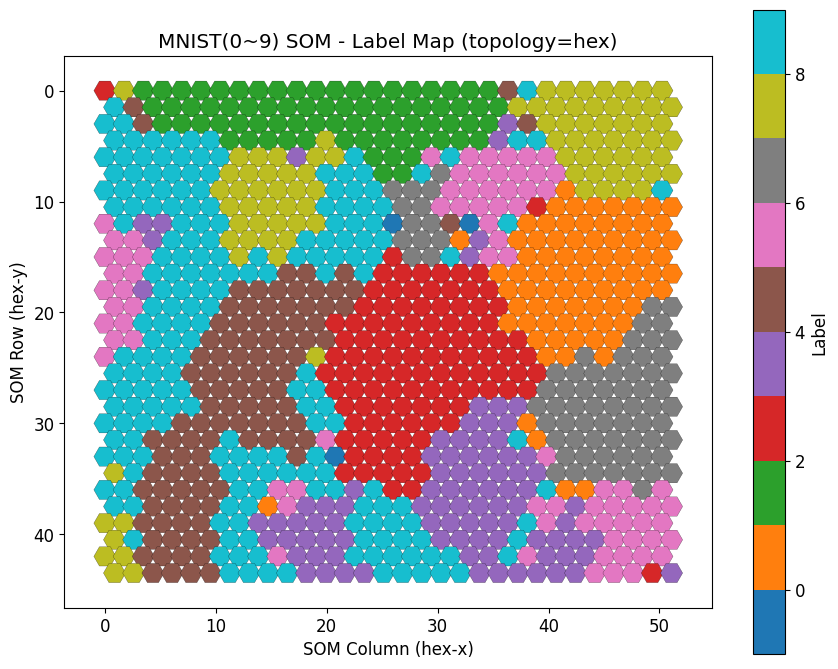

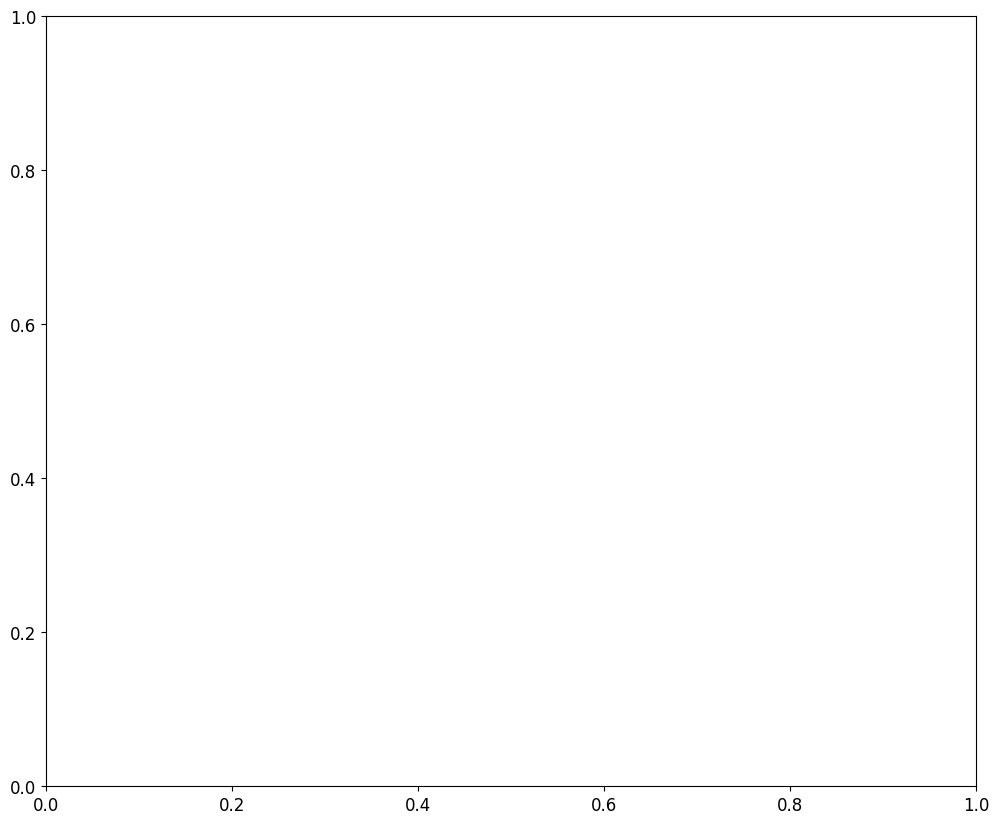

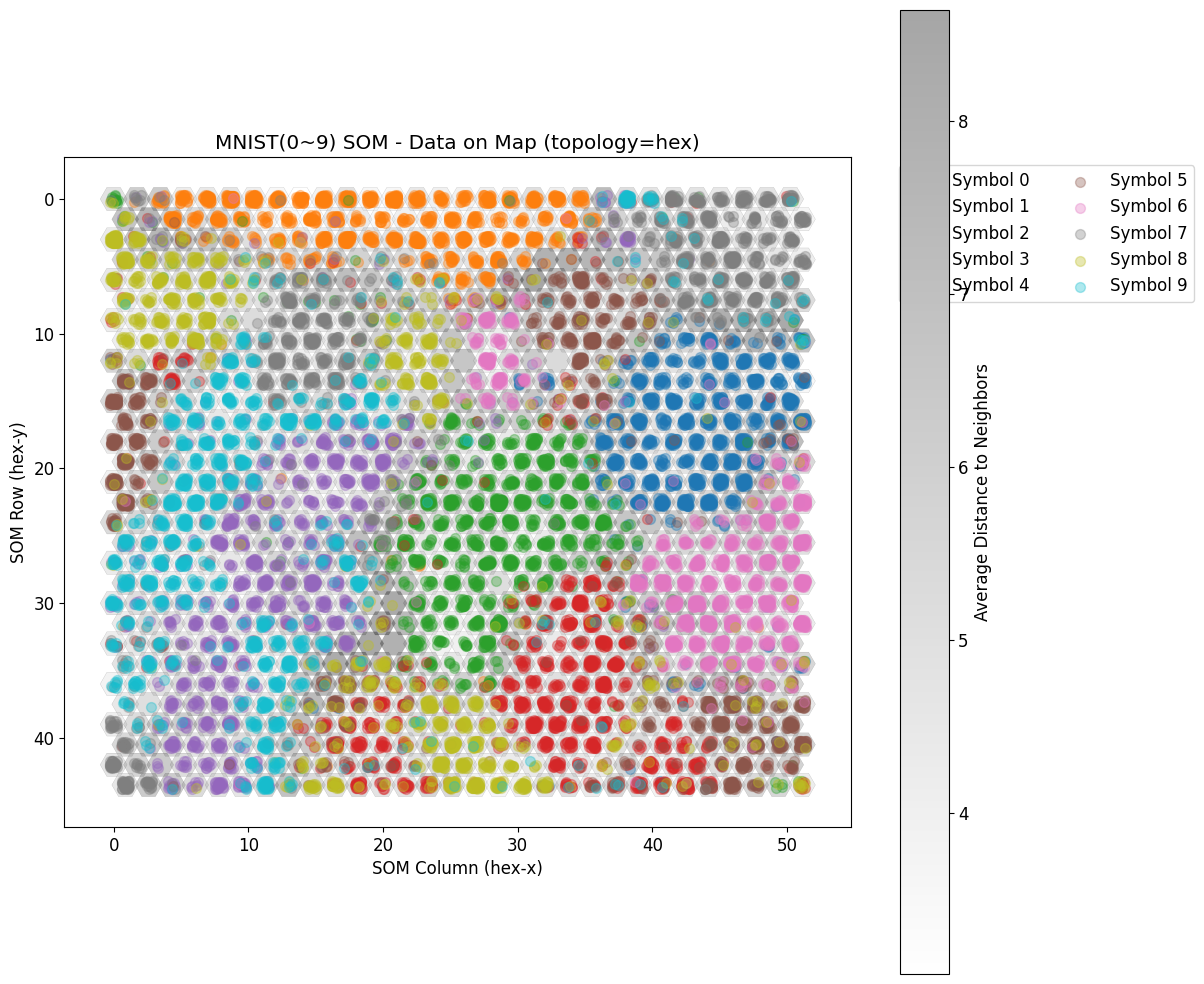

In [ ]:
# 결과 시각화: U-matrix + (0~9) 라벨 맵 + 데이터 산점도
fig, ax = som.plot_u_matrix(figsize=(9, 7), cmap='viridis')
plt.title(f'MNIST(0~9) SOM - U-Matrix (topology={TOPOLOGY})')
plt.show()

fig, ax = som.plot_winner_map(X_in, labels=y, figsize=(9, 7), cmap='tab10')
plt.title(f'MNIST(0~9) SOM - Label Map (topology={TOPOLOGY})')
plt.show()

# 점들을 맵 위에 찍기(색=0~9)
som.plot_data_on_map(X_in, labels=y, figsize=(12, 10), cmap='tab10', alpha=0.35)
plt.title(f'MNIST(0~9) SOM - Data on Map (topology={TOPOLOGY})')
plt.show()

## SOM 프로토타입(가중치) 이미지 타일 시각화

각 뉴런의 가중치 벡터를 28×28 이미지로 되돌려(가능하면 PCA inverse) 한 장의 큰 캔버스로 보여줍니다.

- `USE_PCA=True`면: `pca.inverse_transform`로 픽셀(784)로 근사 복원 후 시각화
- `USE_PCA=False`면: 입력이 784일 때만 그대로 시각화 가능

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def show_som_prototypes(W, map_shape, img_shape=(28, 28), normalize_each=True, figsize_scale=0.35):
    """
    W: (n_nodes, n_features) e.g., (rows*cols, 784)
    map_shape: (rows, cols)
    """
    rows, cols = map_shape
    n_nodes, n_feat = W.shape
    assert n_nodes == rows * cols
    assert n_feat == img_shape[0] * img_shape[1]

    tile_h, tile_w = img_shape
    canvas = np.zeros((rows * tile_h, cols * tile_w), dtype=np.float32)

    for idx in range(n_nodes):
        r, c = divmod(idx, cols)
        img = W[idx].reshape(img_shape).astype(np.float32)

        if normalize_each:
            mn, mx = float(img.min()), float(img.max())
            if mx > mn:
                img = (img - mn) / (mx - mn)

        canvas[r*tile_h:(r+1)*tile_h, c*tile_w:(c+1)*tile_w] = img

    # 화면에 너무 크게 나오지 않게 스케일 조절
    fig_w = max(6, int(cols * figsize_scale))
    fig_h = max(6, int(rows * figsize_scale))
    plt.figure(figsize=(fig_w, fig_h))
    plt.imshow(canvas, cmap='gray', interpolation='nearest')
    plt.axis('off')
    plt.title("SOM prototypes (each node's weight reshaped to image)")
    plt.show()

# SOM 가중치 -> (rows*cols, dim)
rows, cols = MAP_SIZE
W = som.weights.reshape(rows * cols, -1)
print('Raw prototype matrix:', W.shape)

# 픽셀(784) 공간으로 복원해서 시각화
if W.shape[1] == 784:
    W_img = W
    print('Visualizing directly in pixel space (784).')
elif 'pca' in globals():
    # PCA 공간(예: 64차원) -> 784로 근사 복원
    W_img = pca.inverse_transform(W)
    print('Visualizing PCA-inversed prototypes:', W_img.shape)
else:
    raise RuntimeError(f'프로토타입 차원={W.shape[1]}이라 28x28로 바로 시각화 불가. PCA를 켜거나(그리고 pca 객체가 있어야 함) 입력을 784로 학습하세요.')

# 보기 좋게 각 타일별 min-max normalize 해서 표시
show_som_prototypes(W_img, map_shape=MAP_SIZE, img_shape=(28, 28), normalize_each=True)

In [ ]:
# (선택) 뉴런별 라벨 분포(순도) 간단 확인
from collections import Counter

rows, cols = MAP_SIZE
label_counts = [[Counter() for _ in range(cols)] for _ in range(rows)]
for xi, yi in zip(X_in, y):
    r, c = som.predict(xi)
    label_counts[r][c][int(yi)] += 1

purity = np.zeros(MAP_SIZE, dtype=float)
hits = np.zeros(MAP_SIZE, dtype=int)
for r in range(rows):
    for c in range(cols):
        total = sum(label_counts[r][c].values())
        hits[r][c] = total
        if total > 0:
            purity[r][c] = max(label_counts[r][c].values()) / total

print('Mean neuron purity (non-empty):', purity[hits > 0].mean() if np.any(hits > 0) else 0.0)

Mean neuron purity (non-empty): 0.8550514060537445


## 튜닝 팁

- 실행이 너무 느리면: `N_PER_CLASS`를 500~1000으로 줄이고, `NUM_ITER`를 5000~8000으로 낮추세요.
- 분리가 흐리면: `MAP_SIZE`를 (35,35)로 키우거나 `NUM_ITER`를 20000 이상으로 올려보세요.
- PCA를 끄고 원본 784차원으로도 가능하지만 보통 PCA가 더 빠르고 안정적입니다.